Postprocessing of experimental data

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


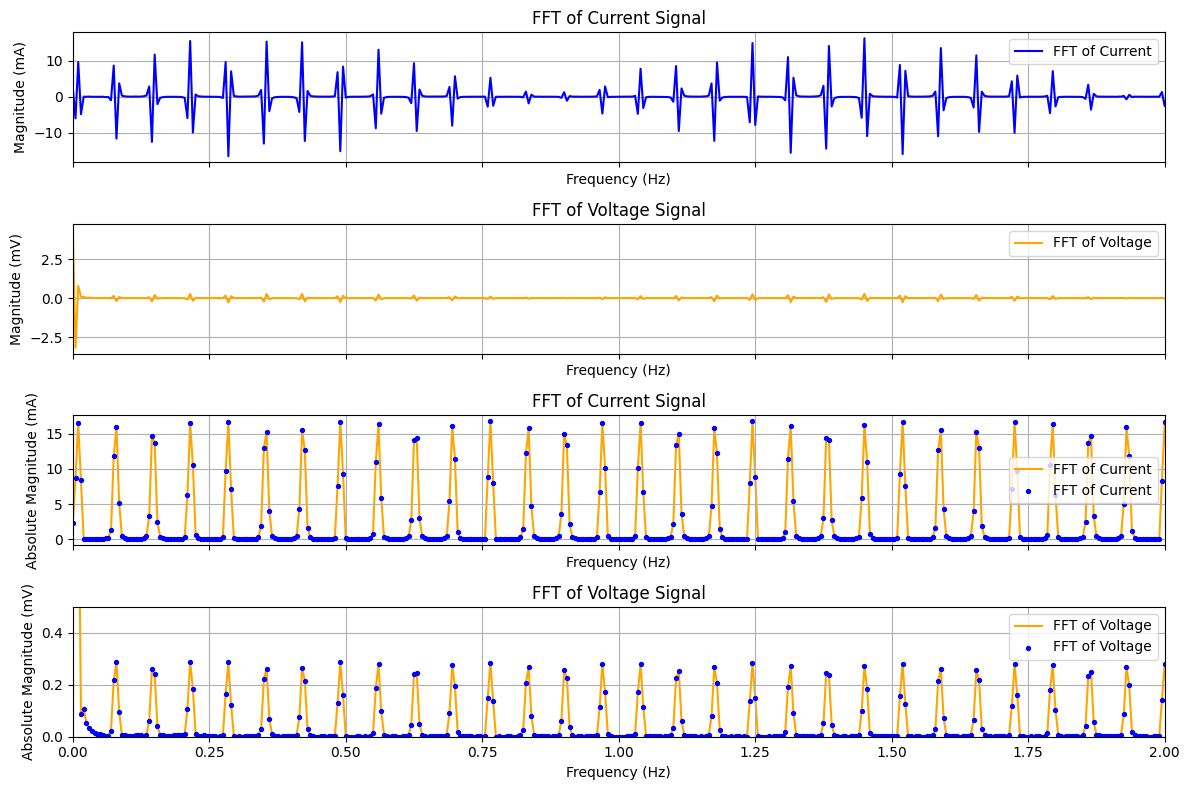

In [2]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq
# for debugging mainly
import matplotlib.pyplot as plt

# ----------------------------
# User parameters
# ----------------------------
cell_capacity_Ah = 3.5       # Ah
window_size_s = 200          # seconds
fs = 200                    # Hz (sampling frequency) (supposedly 1000 Hz, but the data is actually sampled at 200 Hz)
f_pass = 1e-3                # Hz (high-pass filter cutoff)
frequencies = np.logspace(np.log10(0.01), np.log10(2), 30)  # injected f_n
hp_order = 3                 # high-pass filter order

# ----------------------------
# Load BaSyTec exported CSV
# ----------------------------
# CSV must have columns: 'time_s', 'current_A', 'voltage_V'
df = pd.read_csv("LowRes/Joshua_CCSM_lowRes_S50_001_3pt45to3pt8.txt", sep='\t', encoding='unicode_escape')
# Note: unicode_escape is used to handle special characters in the CSV file, such that special characters like 'ï' are read correctly as a string.
t = df['~Time[s]'].to_numpy()
I_raw = df['I[A]'].to_numpy()
U_raw = df['U[V]'].to_numpy()

# ----------------------------
# Plot raw data
# ----------------------------
# plt.figure(figsize=(12, 6))
# plt.plot(t, I_raw, label='Raw Current', color='blue')
# plt.plot(t, U_raw, label='Raw Voltage', color='orange')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Raw Current and Voltage Signals')
# plt.legend()
# plt.grid()
# plt.show()

# ----------------------------
# Trim data
# ----------------------------
mask_beginning = t >= 20  # Start trimming from 20 seconds
mask_ending = t <= 2000  # End trimming at 2000 seconds (because for some reason the charge stops after 3.8 despite limit being 4.2)
t = t[mask_beginning & mask_ending]
I_raw = I_raw[mask_beginning & mask_ending]
U_raw = U_raw[mask_beginning & mask_ending]



# ----------------------------
# Plot the trimmed raw data
# ----------------------------

# Plot current on the left y-axis

# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.plot(t, I_raw, label='Raw Input Current (I)', color='blue')
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Current (A)', color='blue')
# ax1.legend(loc='upper left')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Create a second y-axis for voltage
# ax2 = ax1.twinx()
# ax2.plot(t, U_raw, label='Raw Output Voltage (V)', color='orange')
# ax2.set_ylabel('Voltage (V)', color='orange')
# ax2.legend(loc='upper right')
# ax2.tick_params(axis='y', labelcolor='orange')

# # Title and grid
# plt.title('Raw Current and Voltage Signals')
# fig.tight_layout()
# plt.grid(True)

# plt.show()


# ----------------------------
# Preprocess data
# ----------------------------
# High-pass filter the raw current and voltage data
def highpass_filter(data, fs, f_pass, order):
    nyquist = 0.5 * fs
    normal_cutoff = f_pass / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

I_filtered = highpass_filter(I_raw, fs, f_pass, hp_order)
U_filtered = highpass_filter(U_raw, fs, f_pass, hp_order)
# ----------------------------
# Windowing
# ----------------------------
# Create a Hann window
window_size = int(window_size_s * fs)  # Convert seconds to samples
hann_window = hann(window_size)
# Apply the window to the filtered current and voltage data
I_windowed = I_filtered[:window_size] * hann_window
U_windowed = U_filtered[:window_size] * hann_window

# ----------------------------
# FFT
# ----------------------------
# Compute FFT of the windowed data
def compute_fft(data, fs):  
    N = len(data)
    fft_values = np.fft.fft(data) # or use scipy.fft.fft(data)
    fft_freqs = np.fft.fftfreq(N, 1/fs) # or use scipy.fft.fftfreq(N, 1/fs)
    # return fft_freqs[:N//2], np.abs(fft_values[:N//2]) ## no absolute!!
    return fft_freqs[:N//2], fft_values[:N//2] ## no absolute!!

def compute_abs_fft(data, fs):  
    N = len(data)
    fft_values = np.fft.fft(data) # or use scipy.fft.fft(data)
    fft_freqs = np.fft.fftfreq(N, 1/fs) # or use scipy.fft.fftfreq(N, 1/fs)
    return fft_freqs[:N//2], np.abs(fft_values[:N//2]) #//2 be

I_fft_freqs, I_fft_values = compute_fft(I_windowed, fs)
U_fft_freqs, U_fft_values = compute_fft(U_windowed, fs)


# Hann window, for example, has an amplitude correction factor of about 2.0 + magnitudes should be normalized
I_fft_values *= 2.0 / np.sum(hann_window)
U_fft_values *= 2.0 / np.sum(hann_window)

I_fft_freqs, I_fft_abs_values = compute_abs_fft(I_windowed, fs)
U_fft_freqs, U_fft_abs_values = compute_abs_fft(U_windowed, fs)

# Hann window, for example, has an amplitude correction factor of about 2.0 + magnitudes should be normalized
I_fft_abs_values *= 2.0 / np.sum(hann_window)
U_fft_abs_values *= 2.0 / np.sum(hann_window)

# converting units to millivolts and milliamps
I_fft_values *= 1000  # Convert to mA
U_fft_values *= 1000  # Convert to mV
I_fft_abs_values *= 1000  # Convert to mA
U_fft_abs_values *= 1000  # Convert to mV 
# ----------------------------
# Plotting the FFT results
# ----------------------------
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True) 
# 4.1 Plotting FFT of current
axs[0].plot(I_fft_freqs, I_fft_values, label='FFT of Current', color='blue')
axs[0].set_ylabel('Magnitude (mA)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_title('FFT of Current Signal')
axs[0].legend()
axs[0].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[0].grid()
# 4.2 Plotting FFT of voltage
axs[1].plot(U_fft_freqs, U_fft_values, label='FFT of Voltage', color='orange')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude (mV)')
axs[1].set_title('FFT of Voltage Signal')
axs[1].legend()
axs[1].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[1].grid()

axs[2].plot(I_fft_freqs, I_fft_abs_values, label='FFT of Current', color='orange', zorder=1)
axs[2].scatter(I_fft_freqs, I_fft_abs_values, label='FFT of Current', color='blue', zorder=2, s=8)  # Scatter plot for better visibility
axs[2].set_ylabel('Absolute Magnitude (mA)')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_title('FFT of Current Signal')
axs[2].legend()
axs[2].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[2].grid()
# 4.2 Plotting FFT of voltage
axs[3].plot(U_fft_freqs, U_fft_abs_values, label='FFT of Voltage', color='orange', zorder=1)
axs[3].scatter(U_fft_freqs, U_fft_abs_values, label='FFT of Voltage', color='blue', s=8, zorder=2)  # Scatter plot for better visibility
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('Absolute Magnitude (mV)')
axs[3].set_ylim(0, 0.5)
axs[3].set_title('FFT of Voltage Signal')
axs[3].legend()
axs[3].set_xlim(0, 2)  # Limit x-axis to 10 Hz for better visibility
axs[3].grid()
plt.tight_layout()
plt.show()
# ----------------------------

length of U_ff_values_filtered:  52
[0.01792885-0.00167402j 0.0177518 -0.00118766j 0.01764876-0.00125937j
 0.0174245 -0.00108249j 0.01750945-0.00072082j 0.01719143-0.00085346j
 0.01708765-0.00088509j 0.01718529-0.00080716j 0.01716305-0.00079926j
 0.01712139-0.00066077j 0.01712541-0.0005943j  0.0170485 -0.00075136j
 0.01709663-0.00057613j 0.01706681-0.00061025j 0.01709151-0.00055239j
 0.01701678-0.0007213j  0.01709016-0.00050092j 0.01704317-0.00052257j
 0.0170399 -0.00060226j 0.01701651-0.00042504j 0.01706678-0.00054661j
 0.01706347-0.00039023j 0.01698063-0.00052344j 0.01705438-0.00044738j
 0.01703966-0.00072497j 0.01697848-0.00053195j 0.01680538-0.00052579j
 0.01687576-0.00039135j 0.01696875-0.00062282j 0.01697128-0.00048382j
 0.0169082 -0.00047295j 0.01686913-0.00057299j 0.01688653-0.00043655j
 0.01694532-0.00060254j 0.01696901-0.00045628j 0.01685027-0.00060347j
 0.01685418-0.00056833j 0.01686074-0.0004268j  0.01690136-0.00063004j
 0.01691707-0.00041848j 0.01681034-0.00050501j 0.01684

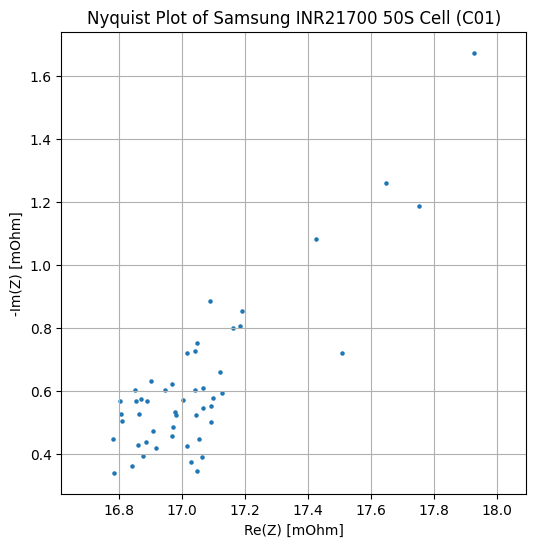

In [3]:
# only compute impedance if current is significantly non-zero
U_fft_values_filtered = U_fft_values[I_fft_abs_values > 10]  # filter out near-zero values of current
I_fft_values_filtered = I_fft_values[I_fft_abs_values > 10]  # filter out near-zero values of current

print("length of U_ff_values_filtered: ", len(U_fft_values_filtered))

# Compute impedance at each frequency
Z = U_fft_values_filtered / I_fft_values_filtered
# filter out negative real parts and positive imaginary parts 
Z = Z[(Z.real > 0) & (Z.imag < 0)]


# Nyquist plot: Imaginary vs Real part of Z
plt.figure(figsize=(6, 6))
# print(Z.real)
print(Z[1:])

# Converting to mOhm
Z *= 1000 # Ohm to mOhm

plt.scatter(Z.real[1:], -Z.imag[1:], s = 5)  # Nyquist: Im(Z) is plotted negative y
plt.xlabel('Re(Z) [mOhm]')
plt.ylabel('-Im(Z) [mOhm]')
plt.title('Nyquist Plot of Samsung INR21700 50S Cell (C01)')
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
## Changing the script to plot Nyquist plot at different SOC (different U_we potentials)
U_windowed_list = np.zeros(len(I_raw)//window_size_s, dtype=object)
I_windowed_list = np.zeros(len(I_raw)//window_size_s, dtype=object)
index = np.arange(0, len(I_raw) - window_size_s, window_size)

print("window size s:", window_size_s)
print("window size s:", window_size_s)

for i in index:
    I_windowed = I_filtered[index[i]:index[i] + window_size] * hann_window
    U_windowed = U_filtered[index[i]:index[i] + window_size] * hann_window
    U_windowed_list[i] = I_windowed
    U_windowed_list[i] = U_windowed

print(U_windowed_list)

window size: <built-in function len>


IndexError: index 40000 is out of bounds for axis 0 with size 10

Original 1D array: [1 2 5 6]
Array after inserting [3] at index 2: [1 2 3 5 6]
Array after inserting [3, 4] at index 2: [1 2 3 4 5 6]

Original 2D array:
[[1 2]
 [5 6]]
Array after inserting row [3, 4] at index 1 (axis=0):
[[1 2]
 [3 4]
 [5 6]]
Array after inserting column [3, 7] at index 1 (axis=1):
[[1 3 2]
 [5 7 6]]


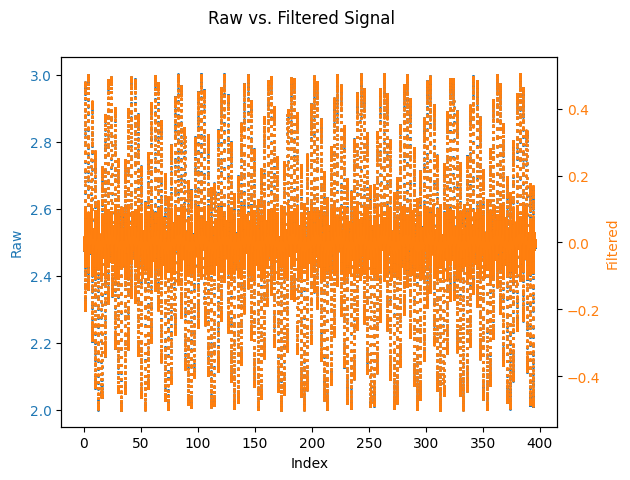

I_raw [2.49492333 2.4936164  2.4936164  ... 2.50145796 2.50211143 2.50015104]
I_filtered [-0.00297469 -0.00428164 -0.00428165 ...  0.00391874  0.00457227
  0.00261194]


In [ ]:
'''
    Dmonstration of the DC filter
    shows how the raw and filtered signals look like; the high pass filter filters out the DC bias.
    uhh this doesn't work, whatever
'''

fig, ax1 = plt.subplots()

# Plot I_raw on left y-axis
color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Raw', color=color)
ax1.scatter(t[:len(I_raw)], I_raw, color=color, label='Raw', s=1)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Filtered', color=color)
ax2.scatter(t[:len(I_filtered)], I_filtered, color=color, label='Filtered', s=1)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Raw vs. Filtered Signal')

plt.show()

print("I_raw", I_raw)
print("I_filtered", I_filtered)

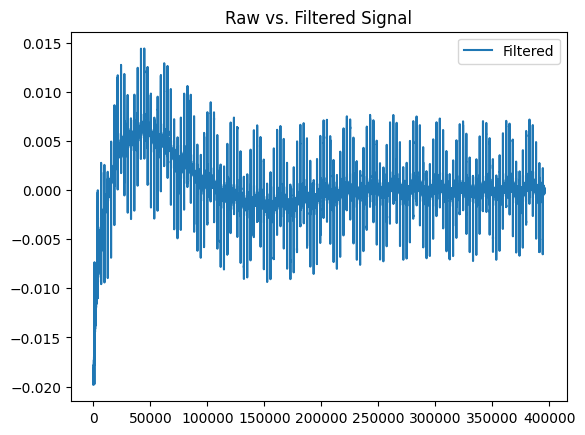

In [ ]:
'''
    Debugging code: 
    shows how the raw and filtered voltage signals look like; the high pass filter filters out the DC bias.
'''
plt.figure()
# plt.plot(U_raw, label='Raw')
plt.plot(U_filtered, label='Filtered')
plt.legend()
plt.title('Raw vs. Filtered Signal')
plt.show()

I_fft_freqs [0.0000e+00 5.0000e-03 1.0000e-02 ... 9.9985e+01 9.9990e+01 9.9995e+01]


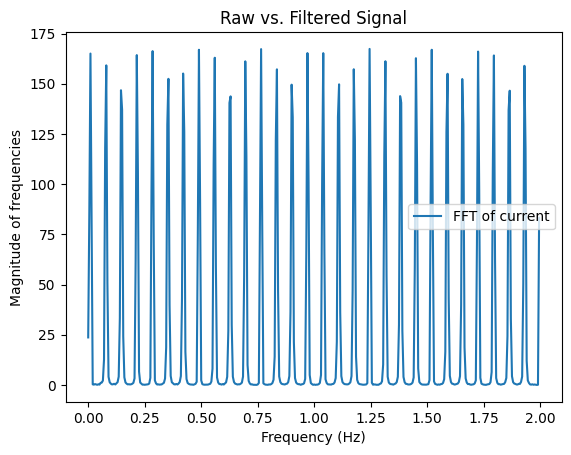

In [ ]:
'''
    Debugging code: 
    shows the post-fft results of the current signal.
'''
print("I_fft_freqs", I_fft_freqs)
plt.figure()
plt.plot(I_fft_freqs[:400],abs(I_fft_values[:400]), label='FFT of current')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of frequencies')
plt.legend()
plt.title('Raw vs. Filtered Signal')
plt.show()

In [ ]:
# np.isinf(U_fft_values).any()
print(np.any(~np.isfinite(I_fft_values)))  # Check if there are any non-finite values in the FFT results
print(I_fft_values.shape)
print(I_fft_values.dtype)

print(np.any(~np.isfinite(U_fft_values)))  # Check if there are any non-finite values in the FFT results
print(U_fft_values.shape)
print(U_fft_values.dtype)


False
(20000,)
complex128
False
(20000,)
complex128


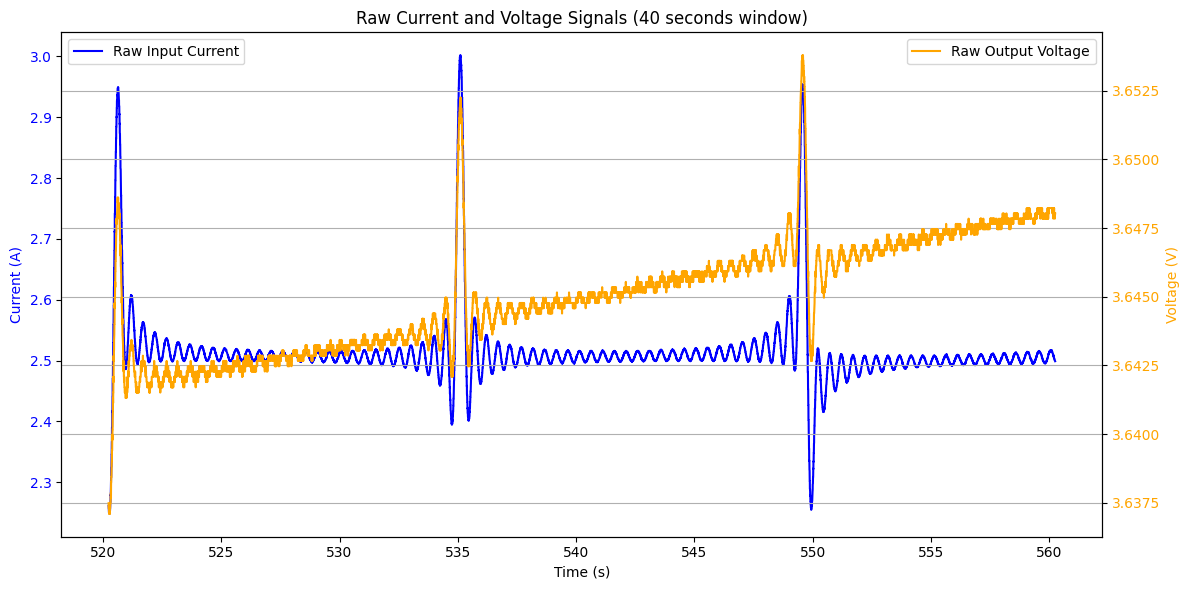

In [ ]:
### Plotting with a window of 200 seconds
window_size_s = 40  # seconds
window_size_samples = int(window_size_s * fs)  # Convert window size to samples

fig, ax1 = plt.subplots(figsize=(12, 6))

start_time = 500
start_index = start_time * fs

# Plot current on the left y-axis
ax1.plot(t[start_index: start_index + window_size_samples], I_raw[start_index: start_index + window_size_samples], label='Raw Input Current', color='blue')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Current (A)', color='blue')
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for voltage
ax2 = ax1.twinx()
ax2.plot(t[start_index: start_index + window_size_samples], U_raw[start_index: start_index + window_size_samples], label='Raw Output Voltage', color='orange')
ax2.set_ylabel('Voltage (V)', color='orange')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and grid
plt.title('Raw Current and Voltage Signals (40 seconds window)')
fig.tight_layout()
plt.grid(True)

plt.show()

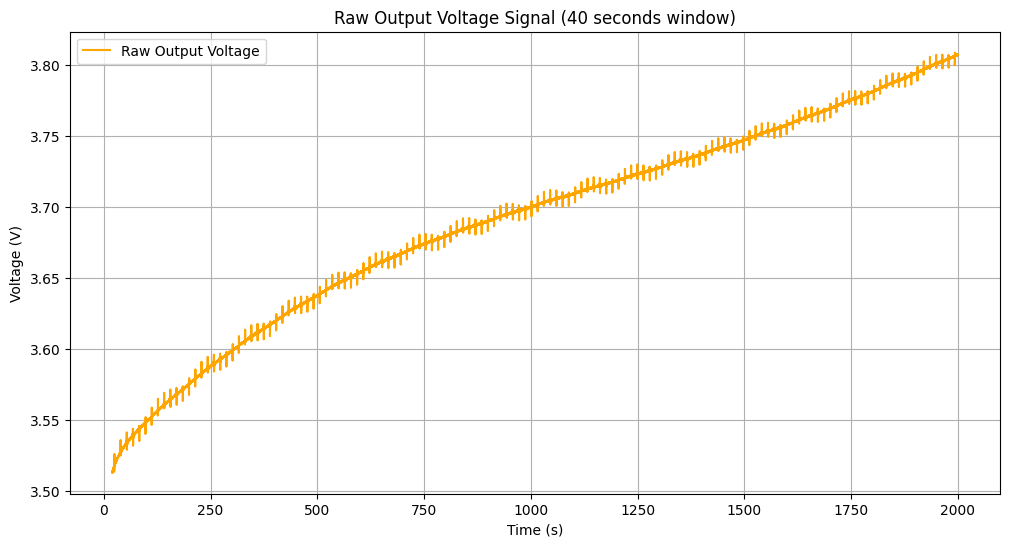

In [ ]:
# Plotting only the voltage response
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t, U_raw,label='Raw Output Voltage', color='orange')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.legend()
ax.set_title('Raw Output Voltage Signal (40 seconds window)')
plt.grid()
plt.show()

In [ ]:
# testing random signal FFT
import numpy as np
t = np.linspace(0, 1, 512, endpoint=False)
signal = np.sin(2*np.pi*50*t) + 0.5*np.sin(2*np.pi*120*t)
fft_vals = np.fft.fft(signal)
print("Imaginary part:", fft_vals.imag)  # Should NOT be all zeros

Imaginary part: [ 0.00000000e+00 -7.35538646e-14 -6.73905376e-14  4.93247952e-14
  2.83524562e-14  3.43732599e-14  3.84137167e-14 -6.40741894e-14
  8.03801470e-14  7.90344644e-14 -2.93967306e-13  1.04618053e-13
 -9.96361969e-14 -8.65889423e-14  9.94759830e-14  8.53653070e-14
 -2.36337509e-14  7.78245706e-15  2.06768335e-13 -4.14323387e-13
  3.73416845e-14 -5.13978542e-13  2.03699360e-13  2.74822251e-14
 -6.07333169e-14  1.28274713e-13  7.70530804e-14 -3.32553130e-13
 -5.14294956e-14 -4.53118999e-13  4.98608189e-14 -1.38702839e-14
 -6.29619992e-14  6.64491360e-14 -4.76423631e-14 -2.51413410e-14
  3.15989161e-14 -4.20552851e-14  2.20884210e-14  9.50791701e-15
 -3.52173915e-14 -4.96845688e-14 -1.53987862e-13 -6.45081002e-14
  5.97366611e-14 -2.23291165e-14 -7.90481772e-14  2.70290211e-14
  1.79146271e-13 -3.74150171e-13 -2.56000000e+02 -2.06104918e-13
  1.44801984e-13  1.02299044e-13  3.16491249e-14  6.45264713e-14
  9.68114477e-14 -3.36519404e-14  6.94103012e-14  1.97184498e-13
 -5.66574

frequencies:  [0.01       0.07862069 0.14724138 0.21586207 0.28448276 0.35310345
 0.42172414 0.49034483 0.55896552 0.62758621 0.6962069  0.76482759
 0.83344828 0.90206897 0.97068966 1.03931034 1.10793103 1.17655172
 1.24517241 1.3137931  1.38241379 1.45103448 1.51965517 1.58827586
 1.65689655 1.72551724 1.79413793 1.86275862 1.93137931 2.        ]
I_amp 0.5


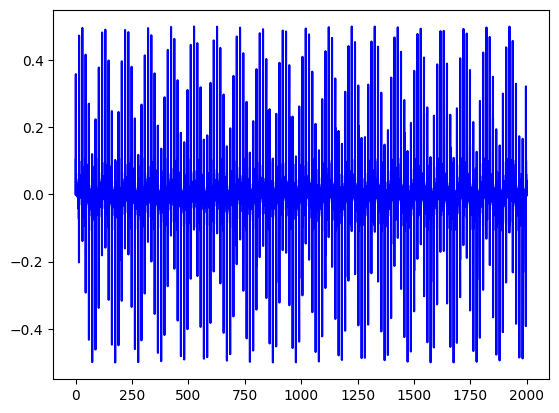

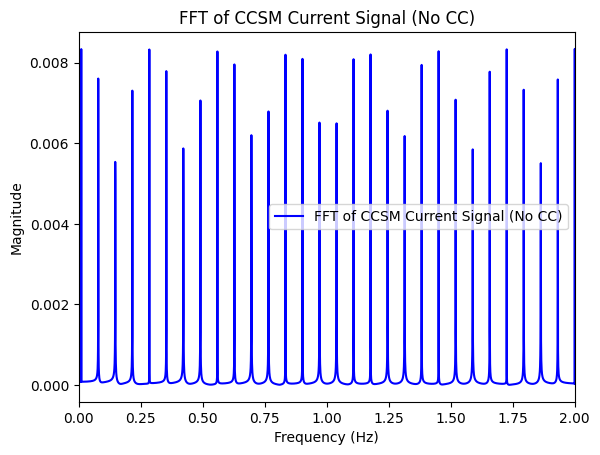

In [ ]:
# Debugging: solving the magnitude overestimation issue by using the raw current input (superposition of sine waves), 
# and yield the amplitude of signal to see if magnitude is consistent

# 1. Discretizing time
fs = 1000  # Sampling frequency in Hz

duration = 2000 # Duration of the signal in seconds 
'''
common mistake is putting 200 here: 200 refers to the window length in the literature, whereas duration is the full charging curve
Nonetheless, runtime is long for anything longer than that, so 200 is good for visualization purposes, though do switch it back
'''
t = np.arange(0, duration, 1/fs)  # Time list

t = np.round(t, 3)  # Round time to 3 decimal places

cell_capacity_Ah = 5 # cell capacity in Ampere-hours determined from the C/10 charge-discharge cycle
I_CC = 0.5 * cell_capacity_Ah  # 0.5 C = 2.5 A # [we're changing C-rates in the future, to assess the effect of C-rate on impedance when it comes to lithium plating]

# 2. Discretizing frequency

# frequencies = np.logspace(np.log10(0.01), np.log10(2), 30) # Frequencies from 0.01 Hz to 2 Hz logarithmically 
# Note: Table 3 of literature used equidisatnce frequencies for the impedance spectrum
N = 30 # number of frequencies (TO_BE_CUSTOMIZED)
frequencies = np.linspace(0.01, 2, N)  # Frequencies from 0.01 Hz to 2 Hz linearly spaced
print("frequencies: ", frequencies)

I_amp = 0.2 * I_CC # Amplitude of each frequency component = 0.2 * I_CC = 0.2 * 2.5 = 0.5 A
print("I_amp", I_amp)

# 3. Generating the CCSM waveform

amp_f = I_amp / N  # Amplitude of each frequency component = 0.5 / N = 0.5 / 30 = 0.016666666666666666 A

I_signal_noCC = (amp_f) * np.sum(
    [np.sin(2 * np.pi * f * t) for f in frequencies],
    axis=0
)

plt.plot(t, I_signal_noCC, label='CCSM Current Signal (No CC)', color='blue')

# do fft on I_signal_noCC
I_signal_noCC_fft = np.fft.fft(I_signal_noCC)

I_signal_noCC_fft_magnitude = np.abs(I_signal_noCC_fft) / len(I_signal_noCC)  # Normalize by duration and sampling frequency

I_signal_noCC_fft_freqs = np.fft.fftfreq(len(I_signal_noCC), 1/fs)
plt.figure()
plt.plot(I_signal_noCC_fft_freqs[:len(I_signal_noCC)//2], I_signal_noCC_fft_magnitude[:len(I_signal_noCC)//2], label='FFT of CCSM Current Signal (No CC)', color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2)  # Limit x-axis to 2 Hz for better visibility
plt.title('FFT of CCSM Current Signal (No CC)')
plt.legend()
